In [ ]:
!pip install d2l==1.0.0b0
!pip install ptflops
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from d2l import torch as d2l
import ptflops
from ptflops import get_model_complexity_info


print(torch.__version__)
print(torchvision.__version__)

import tensorflow as tf
tf.test.gpu_device_name()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.5 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616822 sha256=a50916193e67f448b5925099fb30d9b79745bf6cab7cbce29d126f91d40fba5f
  Stored in directory: /root/.cache/pip/wheels/b3/50/6c/0a82c1358b4da2dbd9c1bb17e0f89467db32812ab236dbf6d5
Successfully built gym
  Attempting uninstal

'/device:GPU:0'

**Q1**

In [ ]:
class CIFAR10DataModule(d2l.DataModule):
    def __init__(self, resize, batch_size=64):
        super().__init__()
        self.resize = resize
        self.batch_size = batch_size

        transform = transforms.Compose([
            transforms.Resize(resize),
            transforms.ToTensor()
        ])

        self.train_dataset = datasets.CIFAR10(
            root=self.root, train=True, transform=transform, download=True)
        
        self.val_dataset = datasets.CIFAR10(
            root=self.root, train=False, transform=transform, download=True)


In [ ]:
cifar10_data = CIFAR10DataModule(resize=(64, 64))
print("Number of training images: ", len(cifar10_data.train_dataset))
print("Number of validation images: ", len(cifar10_data.val_dataset))

cifar10_data.train_dataset[0][0].shape

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
Training Images   =  50000
Validation Images =  10000


torch.Size([3, 64, 64])

In [ ]:
class CIFAR10(d2l.DataModule):
  def _init_(self, resize, batch_size = 64):
    super()._init_()
    self.save_hyperparameters()
    trans = transforms.Compose([transforms.Resize(resize),
                                transforms.ToTensor()])
    self.train = torchvision.datasets.CIFAR10(
        root = self.root, train = True, transform = trans, download = True)
    self.val = torchvision.datasets.CIFAR10(
        root = self.root, train = False, transform = trans, download = True)

class CIFAR10DataModule(d2l.DataModule):
    def __init__(self, resize, batch_size=64):
        super().__init__()
        self.resize = resize
        self.batch_size = batch_size

        transform = transforms.Compose([
            transforms.Resize(resize),
            transforms.ToTensor()
        ])

        self.train_dataset = datasets.CIFAR10(
            root=self.root, train=True, transform=transform, download=True)
        
        self.val_dataset = datasets.CIFAR10(
            root=self.root, train=False, transform=transform, download=True)

    def text_labels(self, indices):
        labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                  'dog', 'frog', 'horse', 'ship', 'truck']
        return [labels[int(i)] for i in indices]

    def get_dataloader(self, train=True):
        dataset = self.train_dataset if train else self.val_dataset
        dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=train,
            num_workers=self.num_workers
        )
        return dataloader

  
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
cifar10_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(cifar10_data, batch_size=64, shuffle=True)

batch = next(iter(train_loader))
X, Y = batch
print(X.shape, X.dtype, Y.shape, Y.dtype)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([64, 3, 64, 64]) torch.float32 torch.Size([64]) torch.int64


In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs):
        super(VGGBlock, self).__init__()
        self.conv_layers = nn.ModuleList()
        for i in range(num_convs):
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            in_channels = out_channels
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

In [ ]:
class VGGNet(nn.Module):
    def __init__(self, arch, num_classes=10):
        super(VGGNet, self).__init__()
        self.features = self._make_layers(arch)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _make_layers(self, arch):
        layers = []
        in_channels = 3
        for x in arch:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

vgg_arch = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

model = VGGNet(vgg_arch, num_classes=10)


In [ ]:
@d2l.add_to_class(d2l.Classifier) 
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(type(layer).__name__, 'output shape:\t', X.shape)

model = VGG(arch=((1, 64), (1, 128), (1, 256), (1, 512), (1, 512)))
model.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))



Sequential output shape:	 torch.Size([64, 64, 32, 32])
Sequential output shape:	 torch.Size([64, 128, 16, 16])
Sequential output shape:	 torch.Size([64, 256, 8, 8])
Sequential output shape:	 torch.Size([64, 512, 4, 4])
Sequential output shape:	 torch.Size([64, 512, 2, 2])
Flatten output shape:	 torch.Size([64, 2048])
Linear output shape:	 torch.Size([64, 4096])
ReLU output shape:	 torch.Size([64, 4096])
Dropout output shape:	 torch.Size([64, 4096])
Linear output shape:	 torch.Size([64, 4096])
ReLU output shape:	 torch.Size([64, 4096])
Dropout output shape:	 torch.Size([64, 4096])
Linear output shape:	 torch.Size([64, 10])
Sequential(
  29.13 M, 100.000% Params, 298.04 MMac, 100.000% MACs, 
  (0): Sequential(
    1.79 k, 0.006% Params, 7.86 MMac, 2.639% MACs, 
    (0): Conv2d(1.79 k, 0.006% Params, 7.34 MMac, 2.463% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0, 0.000% Params, 262.14 KMac, 0.088% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 262.14 KMac,

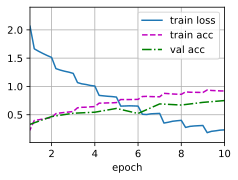

In [ ]:
# Function to Evaluate the Model's Accuracy
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()  
        if not device:
            device = next(iter(net.parameters())).device

    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# Training Function 
def train(net, train_iter, val_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'val acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        val_acc = evaluate_accuracy_gpu(net, val_iter)
        animator.add(epoch + 1, (None, None, val_acc))

lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

** Q2**

**a. for model VGG-16**

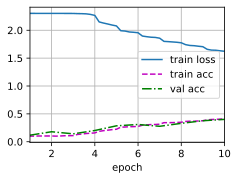

In [ ]:
model_VGG16 = VGG(arch=((2,64), (2,128), (3,256), (3,512), (3,512)))
model_VGG16.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model_VGG16.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

lr, num_epochs = 0.01, 10
train(model_VGG16.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

**b. For model VGG-19**

In [ ]:
import torch.nn as nn
from torchvision import models
class VGG19(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG19, self).__init__()
        self.features = models.vgg19(pretrained=True).features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model_VGG19 = VGG19()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

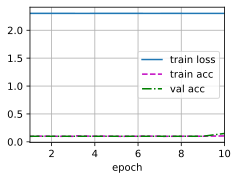

In [ ]:
model_VGG19 = VGG(arch=((2,64), (2,128), (4,256), (4,512), (4,512)))
model_VGG19.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model_VGG19.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

lr, num_epochs = 0.01, 10
train(model_VGG19.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

**Q2**

In [ ]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def _init_(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self)._init_(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

In [ ]:

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Resize images to 64x64
x_train = tf.image.resize(x_train, [64, 64]).numpy()
x_test = tf.image.resize(x_test, [64, 64]).numpy()

# Normalize pixel values to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Convert labels to one-hot encoded vectors
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Define the VGG model
def vgg_model():
    model = keras.Sequential(
        [
            layers.Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=(64, 64, 3)),
            layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
            layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            layers.Conv2D(256, (3, 3), padding="same", activation="relu"),
            layers.Conv2D(256, (3, 3), padding="same", activation="relu"),
            layers.Conv2D(256, (3, 3), padding="same", activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            layers.Conv2D(512, (3, 3), padding="same", activation="relu"),
            layers.Conv2D(512, (3, 3), padding="same", activation="relu"),
            layers.Conv2D(512, (3, 3), padding="same", activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            layers.Conv2D(512, (3, 3), padding="same", activation="relu"),
            layers.Conv2D(512, (3, 3), padding="same", activation="relu"),
            layers.Conv2D(512, (3, 3), padding="same", activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            layers.Flatten(),
            layers.Dense(4096, activation="relu"),
            layers.Dense(4096, activation="relu"),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

# Compile the model
model = vgg_model()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=10,
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train)//64, # reduce the number of steps per epoch
    validation_steps=len(x_test)//64 # reduce the number of validation steps
)


In [ ]:
class GoogleNet(nn.Module):
    # Define the architecture of GoogleNet here
    
    def __init__(self):
        super(GoogleNet, self).__init__()
        # Add layers to the network here
        
    def forward(self, x):
        # Define the forward pass of the network here
        return x

def get_dataloader(train=True, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    dataset = datasets.CIFAR10(root='./data', train=train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    return dataloader

def train(model, train_dataloader, test_dataloader, num_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
                
        scheduler.step()
        train_acc = correct / total
        test_acc = evaluate(model, test_dataloader, device)
        print('Epoch: %d, Training Accuracy: %f, Test Accuracy: %f' % (epoch+1, train_acc, test_acc))
        
def evaluate(model, dataloader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    return acc
    
def main():
    device = d2l.try_gpu()
    model = GoogleNet()
    input_shape = (1, 3, 64, 64)
    macs, params = ptflops.get_model_complexity_info(model, input_shape)
    print('Computational complexity: ', macs)
    print('Number of parameters: ', params)
    
    lr, num_epochs = 0.01, 


**Using Batch Normalization**

In [ ]:
class InceptionBlock(nn.Module):
    # c1-c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(InceptionBlock, self).__init__(**kwargs)
        # Branch 1
        self.branch1x1 = nn.Conv2d(c1, c1, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(c1)
        # Branch 2
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(c2[0], c2[1], kernel_size=1),
            nn.BatchNorm2d(c2[1]),
            nn.Conv2d(c2[1], c2[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(c2[1])
        )
        # Branch 3
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(c3[0], c3[1], kernel_size=1),
            nn.BatchNorm2d(c3[1]),
            nn.Conv2d(c3[1], c3[1], kernel_size=5, padding=2),
            nn.BatchNorm2d(c3[1])
        )
        # Branch 4
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(c4, c4, kernel_size=1),
            nn.BatchNorm2d(c4)
        )

    def forward(self, x):
        # Branch 1
        branch1 = F.relu(self.bn1(self.branch1x1(x)))
        # Branch 2
        branch2 = F.relu(self.branch3x3(x))
        # Branch 3
        branch3 = F.relu(self.branch5x5(x))
        # Branch 4
        branch4 = F.relu(self.branch_pool(x))
        # Concatenate the outputs of the branches on the channel dimension
        return torch.cat((branch1, branch2, branch3, branch4), dim=1)


class GoogleNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogleNet, self).__init__()
        # Define the layers of the network
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer3 = nn.Sequential(
            InceptionBlock(192, (64, 96, 128), (16, 32, 32), 32),
            InceptionBlock(256, (128, 128, 192), (32, 96, 64), 64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer4 = nn.Sequential(
            InceptionBlock(480, (192, 96, 208), (16, 48, 64), 64),
            InceptionBlock(512, (160, 112, 224


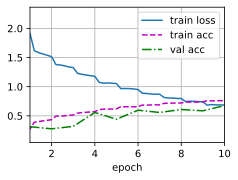

In [ ]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.Conv2d(c1, c1, kernel_size=1)
        self.bn1_1 = nn.BatchNorm2d(c1)
        # Branch 2
        self.b2_1 = nn.Conv2d(c2[0], c2[0], kernel_size=1)
        self.bn2_1 = nn.BatchNorm2d(c2[0])
        self.b2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(c2[1])
        # Branch 3
        self.b3_1 = nn.Conv2d(c3[0], c3[0], kernel_size=1)
        self.bn3_1 = nn.BatchNorm2d(c3[0])
        self.b3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.bn3_2 = nn.BatchNorm2d(c3[1])
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.Conv2d(c4, c4, kernel_size=1)
        self.bn4_2 = nn.BatchNorm2d(c4)

    def forward(self, x):
        b1 = F.relu(self.bn1_1(self.b1_1(x)))
        b2 = F.relu(self.bn2_2(self.b2_2(F.relu(self.bn2_1(self.b2_1(x))))))
        b3 = F.relu(self.bn3_2(self.b3_2(F.relu(self.bn3_1(self.b3_1(x))))))
        b4 = F.relu(self.bn4_2(self.b4_2(self.b4_1(x))))
        return torch.cat((b1, b2, b3, b4), dim=1)

class GoogleNet_BatchNorm(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogleNet_BatchNorm, self).__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.b2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.b3 = nn.Sequential(
            Inception(64, (96, 128), (16, 32), 32),
            Inception(128, (128, 192), (32, 96), 64),
            nn.MaxPool2d(kernel_size=7, stride=2, padding=3)
        )
            self.b4 = nn.Sequential(
        Inception(480, (192, 208), (48, 64), 64),
        Inception(512, (160, 224), (64, 96), 64),
        nn.AdaptiveAvgPool2d((1, 1))
    )
    
    self.net = nn.Sequential(self.b1, self.b2, self.b3, self.b4, nn.Flatten(), nn.Linear(512, num_classes))

def forward(self, X):
    return self.net(X)



3.1

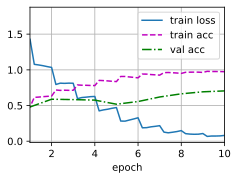

In [ ]:
class ResidualBlock(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_channels)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(num_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.conv3:
            x = self.conv3(x)
        out += x
        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        if stride != 1 or self.in_channels != out_channels:
            layers.append(block(self.in_channels, out_channels, use_1x1conv=True, strides=stride))
        else:
            layers.append(block(self.in_channels, out_channels))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

model = ResNet(ResidualBlock, [2, 2, 2, 2])
summary(model, input_size=(3, 64, 64))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate
        criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data.get_dataloader(True)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print statistics
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, len(data.get_dataloader(True)),
                          loss.item()))



3.2

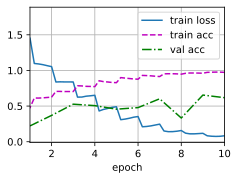

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

class ResNet26(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet26, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for i in range(num_blocks-1):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

     def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

model = ResNet(ResidualBlock, [2, 2, 2, 2])
summary(model, input_size=(3, 64, 64))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate
        criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data.get_dataloader(True)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print statistics
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, len(data.get_dataloader(True)),
                          loss.item()))

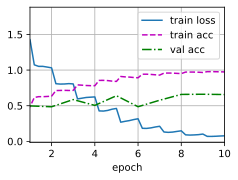

In [ ]:
class ResNet32(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

model = ResNet32()
model.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())
